In [3]:
dados = read.table("recrutas.txt", header=T)
nadar = factor(dados$nadar)
local = factor(dados$local)
idade = factor(dados$idade)
sexo = factor(dados$sexo)
num_infec = dados$num_infec
levels(idade) = c("15-19", "20-29", "20-29")
head(dados)

,nadar,local,idade,sexo,num_infec
,<chr>,<chr>,<chr>,<chr>,<int>
1,Occas,NonBeach,15-19,Male,0
2,Occas,NonBeach,15-19,Male,0
3,Occas,NonBeach,15-19,Male,0
4,Occas,NonBeach,15-19,Male,0
5,Occas,NonBeach,15-19,Male,0
6,Occas,NonBeach,15-19,Male,0


Modelo Poisson

In [4]:
fit.model = glm(formula = num_infec ~ nadar + local + idade, family = poisson)
summary(fit.model)


Call:
glm(formula = num_infec ~ nadar + local + idade, family = poisson)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -0.1699     0.1157  -1.468  0.14223    
nadarOccas      0.6136     0.1050   5.845 5.08e-09 ***
localNonBeach   0.4982     0.1029   4.842 1.28e-06 ***
idade20-29     -0.2742     0.1011  -2.714  0.00666 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 824.51  on 286  degrees of freedom
Residual deviance: 757.23  on 283  degrees of freedom
AIC: 1137.6

Number of Fisher Scoring iterations: 6


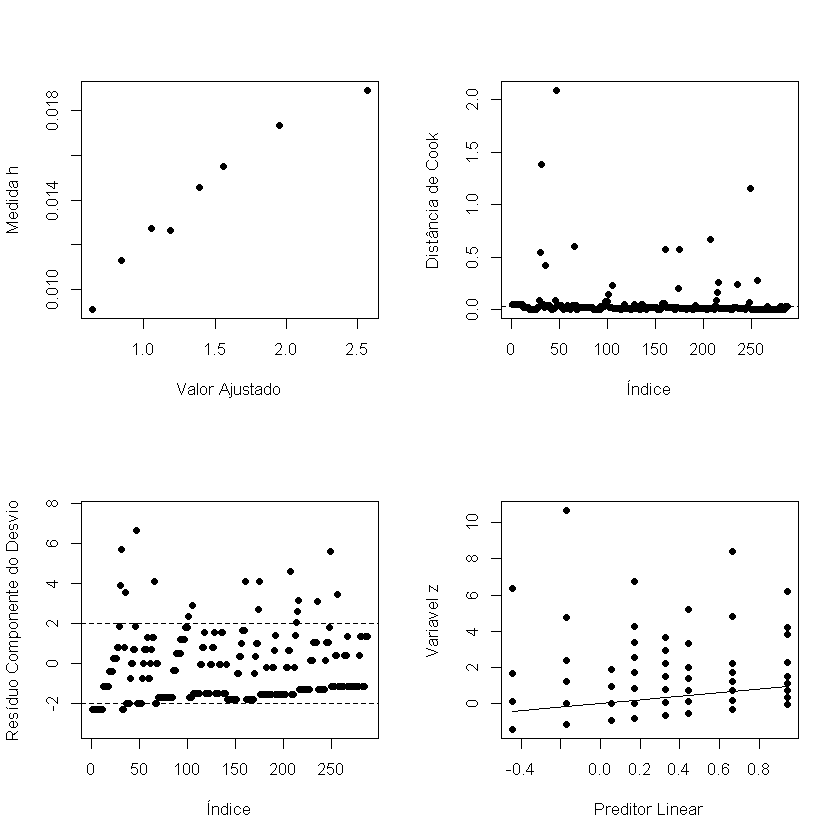

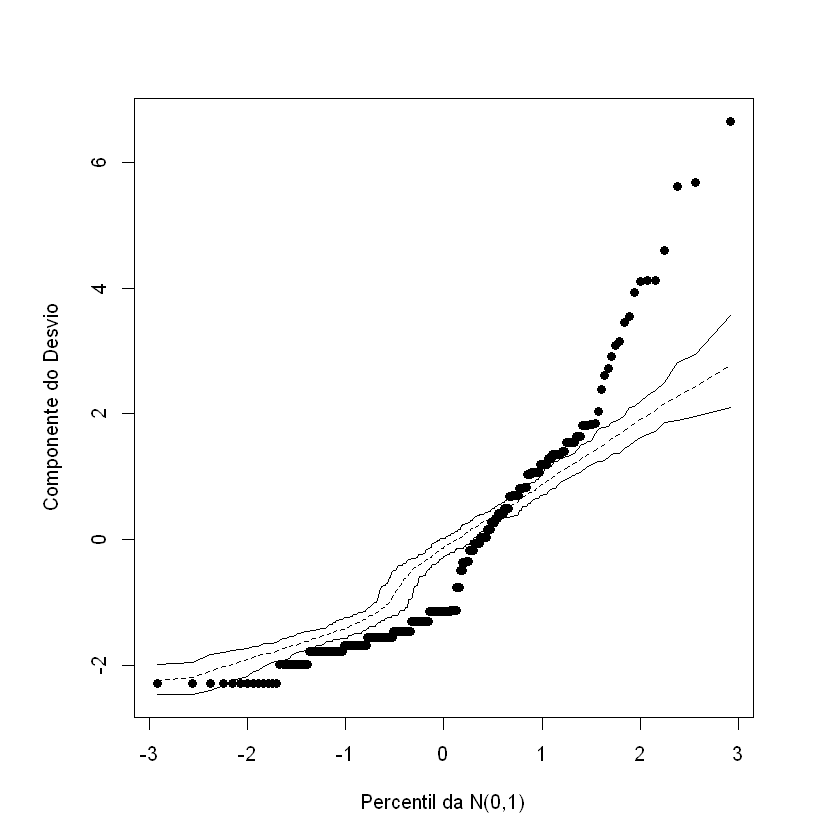

In [5]:
source("C:/Users/moise/Desktop/regressao/capitulo 4/diag_pois.R")
source("C:/Users/moise/Desktop/regressao/capitulo 4/envel_pois.R")

Modelo Quase-Verossimilhança

In [9]:
fit.model = glm(num_infec ~ nadar + local + idade, family=quasipoisson)
summary(fit.model)
phi = summary(fit.model)$dispersion
phi


Call:
glm(formula = num_infec ~ nadar + local + idade, family = quasipoisson)

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)    -0.1699     0.2118  -0.802  0.42325   
nadarOccas      0.6136     0.1921   3.194  0.00156 **
localNonBeach   0.4982     0.1883   2.646  0.00860 **
idade20-29     -0.2742     0.1849  -1.483  0.13923   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasipoisson family taken to be 3.348725)

    Null deviance: 824.51  on 286  degrees of freedom
Residual deviance: 757.23  on 283  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 6


[1] 3.348725

Corrigindo o resíduo componente do desvio:

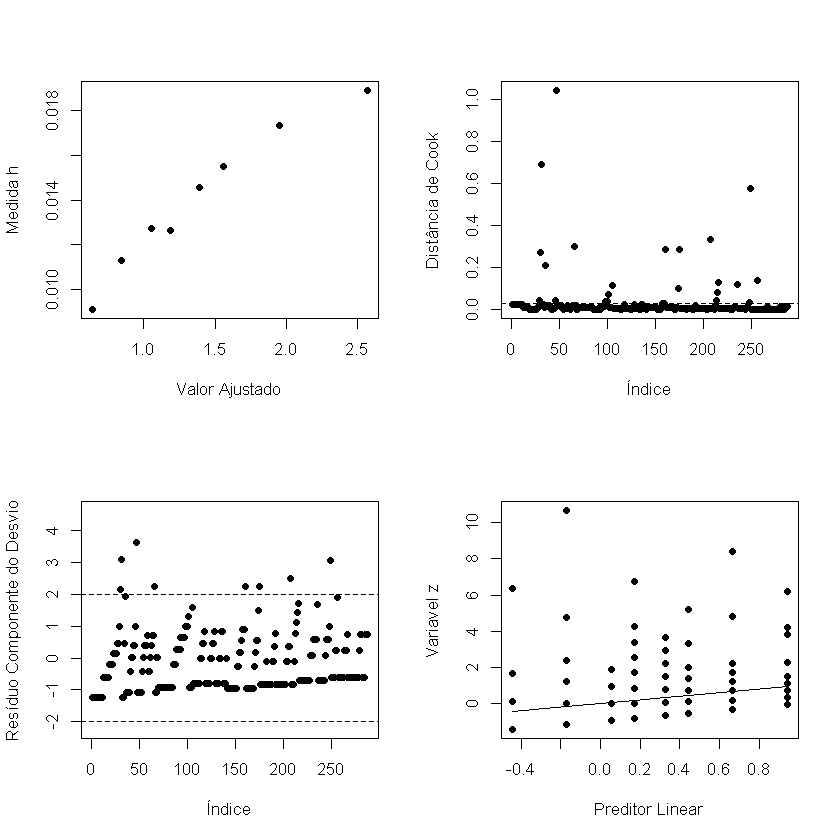

In [13]:
X <- model.matrix(fit.model)
n <- nrow(X)
p <- ncol(X)
w <- fit.model$weights
W <- diag(w)
H <- solve(t(X)%*%W%*%X)
H <- sqrt(W)%*%X%*%H%*%t(X)%*%sqrt(W)
h <- diag(H)
ts <- resid(fit.model,type="pearson")/sqrt(1-h)
td <- resid(fit.model,type="deviance")/(sqrt(phi)*sqrt(1-h))
di <- (h/((1-h)*2))*(ts^2)
par(bg='white',mfrow=c(2,2))
a <- min(td)
b <- max(td)
plot(fitted(fit.model), h,xlab="Valor Ajustado", ylab="Medida h",
pch=16)
#identify(fitted(fit.model), h, n=1)
#
plot(di,xlab="Índice", ylab="Distância de Cook", pch=16)
abline(2*p/n,0,lty=2)
#identify(di, n=1)
#
plot(td,xlab="Índice", ylab="Resíduo Componente do Desvio",
ylim=c(a-1,b+1), pch=16)
abline(2,0,lty=2)
abline(-2,0,lty=2)
#identify(td, n=1)
#
w <- fit.model$weights
eta <- predict(fit.model)
z <- eta + resid(fit.model, type="pearson")/sqrt(w)
plot(predict(fit.model),z,xlab="Preditor Linear", 
ylab="Variavel z", pch=16)
lines(smooth.spline(predict(fit.model), z, df=2))
par(mfrow=c(1,1))

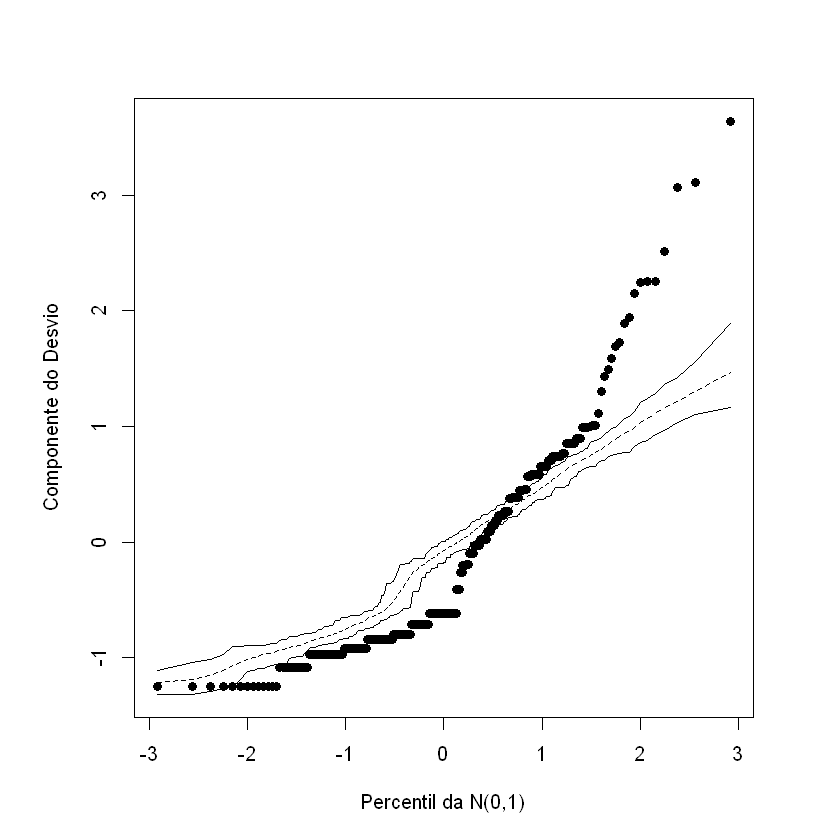

In [15]:
par(mfrow=c(1,1))
X <- model.matrix(fit.model)
n <- nrow(X)
p <- ncol(X)
w <- fit.model$weights
W <- diag(w)
H <- solve(t(X)%*%W%*%X)
H <- sqrt(W)%*%X%*%H%*%t(X)%*%sqrt(W)
h <- diag(H)
td <- resid(fit.model,type="deviance")/(sqrt(phi)*sqrt((1-h)))
e <- matrix(0,n,100)
#
for(i in 1:100){
nresp <- rpois(n, fitted(fit.model))
fit <- glm(nresp ~ X, family=quasipoisson)
w <- fit$weights
W <- diag(w)
H <- solve(t(X)%*%W%*%X)
H <- sqrt(W)%*%X%*%H%*%t(X)%*%sqrt(W)
h <- diag(H)
e[,i] <- sort(resid(fit,type="deviance")/sqrt(phi)*(sqrt(1-h)))}
#
e1 <- numeric(n)
e2 <- numeric(n)
#
for(i in 1:n){
  eo <- sort(e[i,])
e1[i] <- (eo[2]+eo[3])/2
e2[i] <- (eo[97]+eo[98])/2}
#
med <- apply(e,1,mean)
faixa <- range(td,e1,e2)
par(bg='white',pty="s")
qqnorm(td,xlab="Percentil da N(0,1)",
ylab="Componente do Desvio", ylim=faixa, pch=16, main="")
par(new=TRUE)
#
qqnorm(e1,axes=F,xlab="",ylab="",type="l",ylim=faixa,lty=1, main="")
par(new=TRUE)
qqnorm(e2,axes=F,xlab="",ylab="", type="l",ylim=faixa,lty=1, main="")
par(new=TRUE)
qqnorm(med,axes=F,xlab="", ylab="", type="l",ylim=faixa,lty=2, main="")

Modelo Binomial Negativo

In [16]:
library(MASS)
fit.model = glm.nb(num_infec ~ nadar + local + idade)
summary(fit.model)
fit.model$theta


Call:
glm.nb(formula = num_infec ~ nadar + local + idade, init.theta = 0.5728858194, 
    link = log)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)   
(Intercept)    -0.1322     0.1975  -0.669  0.50327   
nadarOccas      0.6117     0.1898   3.222  0.00127 **
localNonBeach   0.4838     0.1893   2.556  0.01058 * 
idade20-29     -0.3349     0.1890  -1.772  0.07644 . 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(0.5729) family taken to be 1)

    Null deviance: 289.09  on 286  degrees of freedom
Residual deviance: 269.10  on 283  degrees of freedom
AIC: 901.4

Number of Fisher Scoring iterations: 1


              Theta:  0.5729 
          Std. Err.:  0.0897 

 2 x log-likelihood:  -891.3990 

[1] 0.5728858

p-valor: 1-pchisq(269.21, 282) = 0.698

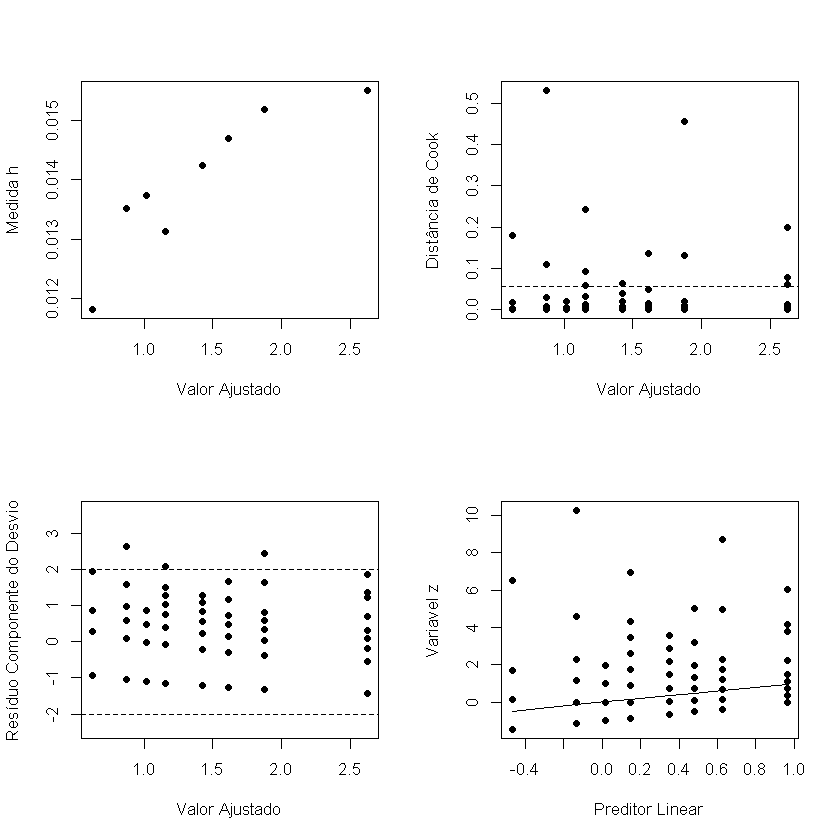

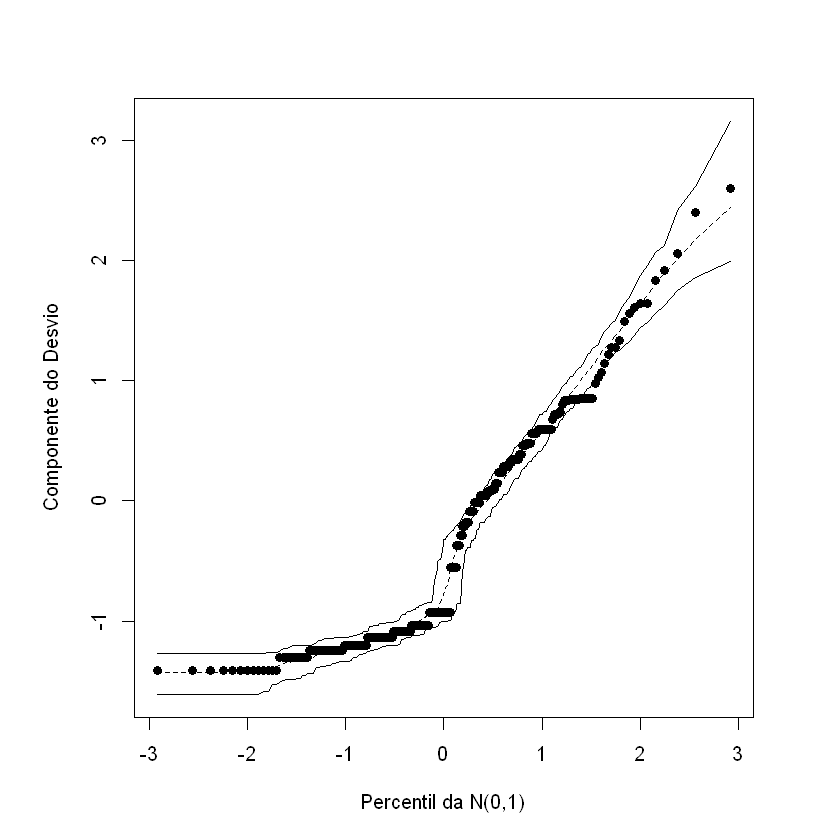

In [17]:
source("C:/Users/moise/Desktop/regressao/capitulo 4/diag_nbin.R")
source("C:/Users/moise/Desktop/regressao/capitulo 4/envel_nbin.R")